In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import numpy as np
import glob
print(cv2.__version__)

4.1.1


### Open the shifted frames (saved from Step2) and calculate dense optical flow using OpenCV

In [2]:
files = sorted(glob.glob('./shifted/*.png'))
files[0:10]

['./shifted/frame0000000.png',
 './shifted/frame0000001.png',
 './shifted/frame0000002.png',
 './shifted/frame0000003.png',
 './shifted/frame0000004.png',
 './shifted/frame0000005.png',
 './shifted/frame0000006.png',
 './shifted/frame0000007.png',
 './shifted/frame0000008.png',
 './shifted/frame0000009.png']

### Define some functions to load and calculate optical flow between two images

In [3]:
def read_frame(fn):
    frame = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
    return frame

def calc_flow(fn1,fn2):
    frame1 = read_frame(fn1)
    frame2 = read_frame(fn2)

    # work out the overlapping area in the frames and the indexes to crop the frames back to 
    mask = (frame1 > 0) & (frame2 > 0)
    cols = np.where(np.any(mask,axis=0))
    rows = np.where(np.any(mask,axis=1))
    rmin = np.min(rows)
    rmax = np.max(rows)
    cmin = np.min(cols)
    cmax = np.max(cols)

    frame1 = frame1[rmin:rmax,cmin:cmax]
    frame2 = frame2[rmin:rmax,cmin:cmax]

    fig,ax=plt.subplots(figsize=(8,8))
    c1=ax.imshow(frame1,cmap='gray')
    plt.colorbar(c1)

    # need to check the parameter values for Farneback algorithm...
    winsize=45
    flow = cv2.calcOpticalFlowFarneback(frame1,frame2, None, 0.5, 5, winsize, 4, 5, 1.1, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    flow=flow[winsize:-winsize,winsize:-winsize,...]
    
    return flow

### Plot optical flow as an example

Text(0.5, 1.0, 'Direction of optical flow')

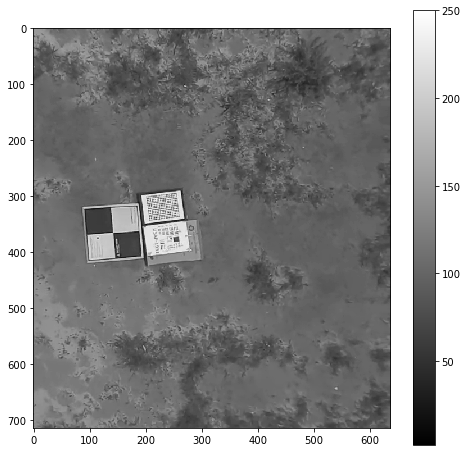

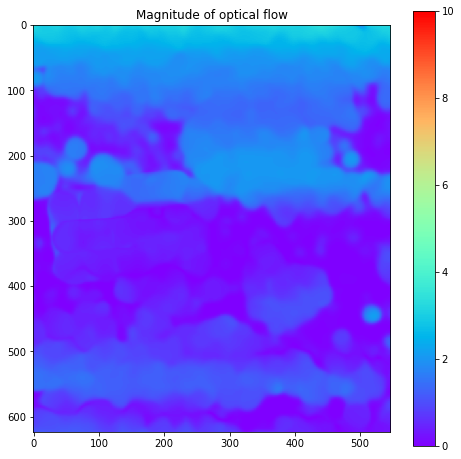

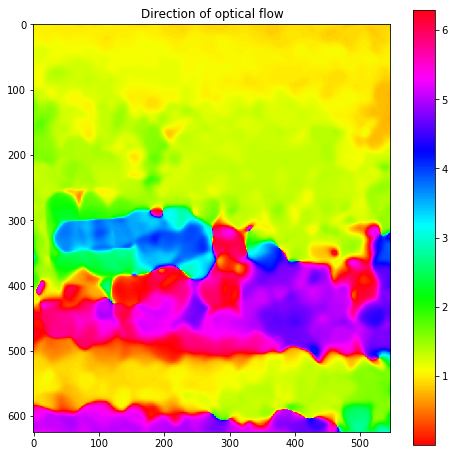

In [4]:
flow = calc_flow(files[100],files[101])

mag, angle = cv2.cartToPolar(flow[...,0],flow[...,1])

fig,ax = plt.subplots(figsize=(8,8))
c1=ax.imshow(mag,cmap='rainbow',vmin=0,vmax=10)
plt.colorbar(c1)
ax.set_title('Magnitude of optical flow')

fig,ax = plt.subplots(figsize=(8,8))
c2=ax.imshow(angle,cmap='hsv')
plt.colorbar(c2)
ax.set_title('Direction of optical flow')

### Locate the region that is always in view and crop the images to that region

In [5]:
from dask import compute, delayed, persist
from distributed import LocalCluster, Client, progress

In [6]:
cluster=LocalCluster(n_workers=7,threads_per_worker=1)
client=Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41919 Dashboard: /user/pbranson/proxy/8787/status,Cluster Workers: 7 Cores: 7 Memory: 25.28 GB


### ^^^ click on the dashboard link to see progress of computations

In [7]:
import dask.array as da

frame = read_frame(files[0])
read_frame_d = delayed(read_frame)
images = [da.from_delayed(read_frame_d(f),shape=frame.shape,dtype=frame.dtype) for f in files]
image_stack = da.stack(images,axis=0)
image_min = compute(da.min(image_stack,axis=0))[0]
image_stack

dask.array<stack, shape=(1006, 844, 872), dtype=uint8, chunksize=(1, 844, 872)>

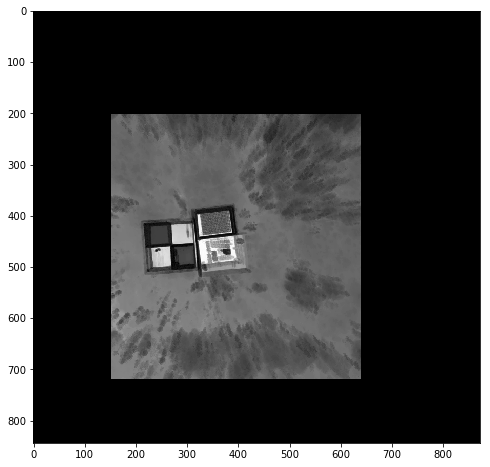

In [8]:
fig,ax = plt.subplots(figsize=(8,8))
c1=ax.imshow(image_min,cmap='gray')

### crop all the files

In [9]:
mask = (image_min > 0)
cols = np.where(np.any(mask,axis=0))
rows = np.where(np.any(mask,axis=1))
rmin = np.min(rows)
rmax = np.max(rows)
cmin = np.min(cols)
cmax = np.max(cols)

if os.path.isdir('cropped'):
    shutil.rmtree('cropped' + '/')
os.mkdir('cropped')

@delayed
def crop_frame(fn,rmin,rmax,cmin,cmax):
    frame = read_frame(fn)
    frame = frame[rmin:rmax,cmin:cmax]
    new_name="./cropped/" + os.path.basename(fn)
    cv2.imwrite(new_name,frame)     # save frame as PNG file
    return new_name

make_crops = [crop_frame(fn,rmin,rmax,cmin,cmax) for fn in files]
cropped_files = compute(make_crops)[0]

In [10]:
cropped_files[0:10]

['./cropped/frame0000000.png',
 './cropped/frame0000001.png',
 './cropped/frame0000002.png',
 './cropped/frame0000003.png',
 './cropped/frame0000004.png',
 './cropped/frame0000005.png',
 './cropped/frame0000006.png',
 './cropped/frame0000007.png',
 './cropped/frame0000008.png',
 './cropped/frame0000009.png']

### pick out an area that has good texture for calculating the optical flow

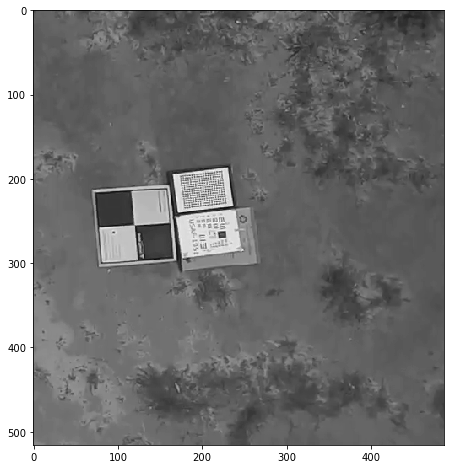

In [11]:
frame = read_frame(cropped_files[800])
fig,ax = plt.subplots(figsize=(8,8))
c1=ax.imshow(frame,cmap='gray')

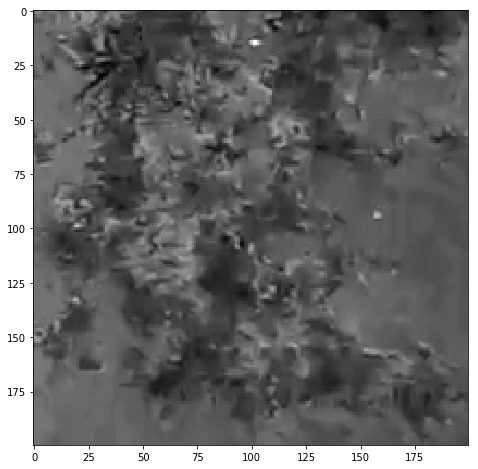

In [12]:
frame = read_frame(cropped_files[800])
roi = frame[20:220,280:480]
fig,ax = plt.subplots(figsize=(8,8))
c1=ax.imshow(roi,cmap='gray')

### Simplified function to calculate optical flow of the cropped images and return the RMS result in the roi

In [13]:
@delayed
def calc_flow(frame1,frame2):
    # need to check the parameter values for Farneback algorithm...
    winsize=45
    flow = cv2.calcOpticalFlowFarneback(frame1,frame2, None, 0.5, 4, winsize, 3, 5, 1.1, 0)# cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    flow=flow[20:220,280:480,...]
    
    #calculate the mean down the image in the direction of the rolling shutter
    u_rms = np.sqrt(np.mean(flow[...,0]**2.))
    v_rms = np.sqrt(np.mean(flow[...,0]**2.))
    rms_flow = np.sqrt(u_rms**2. + v_rms**2.)
    return np.array([u_rms,v_rms,rms_flow])

read_frame_d = delayed(read_frame)
cropped_frames = [read_frame_d(fn) for fn in cropped_files]
video_flow = persist([calc_flow(cropped_frames[f],cropped_frames[f+1]) for f in range(len(cropped_frames)-1)])[0]
progress(video_flow)

VBox()

In [14]:
video_flow = compute(video_flow)[0]
video_flow = np.stack(video_flow,axis=0)

In [15]:
video_flow.shape

(1005, 3)

In [16]:
total_rms = np.sqrt(np.mean(video_flow[:,2] ** 2))
total_rms

1.9421031309703862

Text(0.5, 1.0, 'RMS vibration 1.94 px/frame')

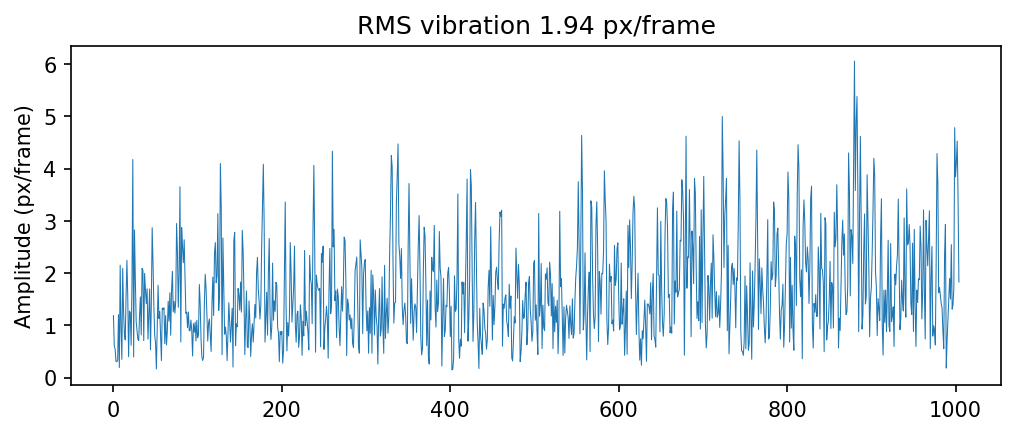

In [17]:
fig,ax = plt.subplots(1,1,figsize=(8,3),dpi=150,sharex=True)
pc=ax.plot(video_flow[:,2],lw=0.5)
ax.set_ylabel('Amplitude (px/frame)')
ax.set_title('RMS vibration %.2f px/frame' % total_rms)
